In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [2]:
from google.colab import files 
uploaded=files.upload()

Saving Airline.xlsx to Airline.xlsx


In [7]:
excel_file = pd.read_excel('Airline.xlsx')
csv_data = excel_file.to_csv(index=False)
with open('Airline.csv', 'w') as f:
    f.write(csv_data)
print("Excel file converted to CSV successfully.")


Excel file converted to CSV successfully.


In [9]:
Airline = pd.read_csv('Airline.csv')

In [11]:
Airline.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [14]:
Airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       96 non-null     object
 1   Passengers  96 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


<Axes: >

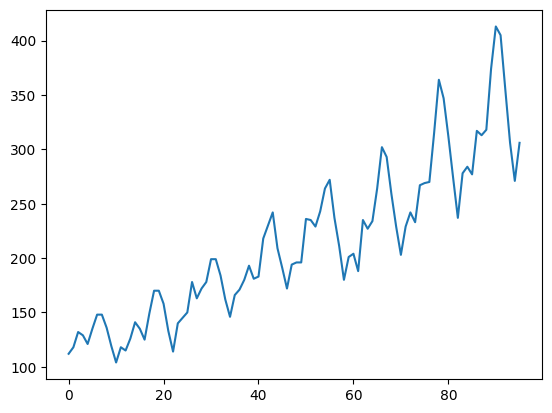

In [16]:
Airline.Passengers.plot()

In [18]:
len(Airline['Passengers'])

96

# Splitting data

In [19]:
Train = Airline.head(147)
Test = Airline.tail(12)

# Moving Average 

In [20]:
list(range(2,24,6))

[2, 8, 14, 20]

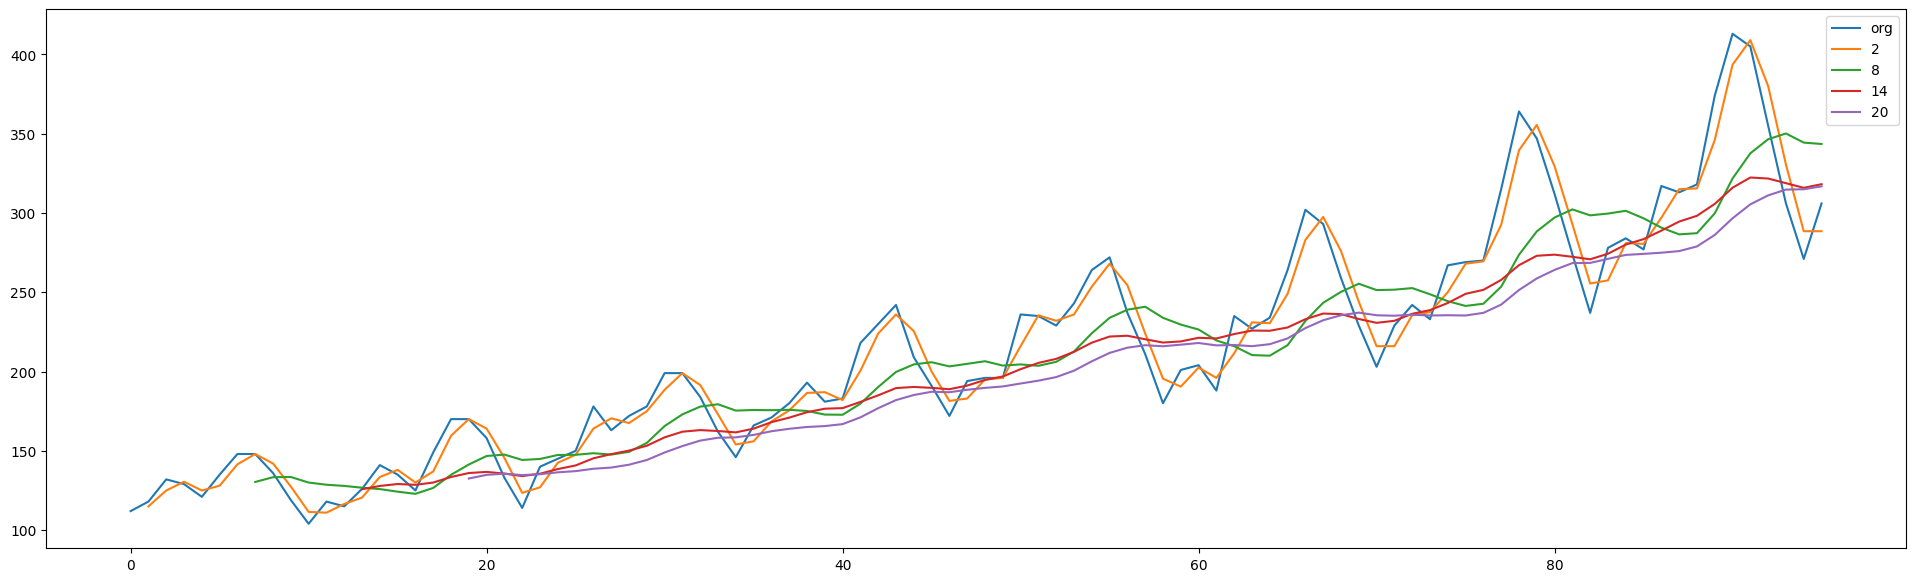

In [21]:
plt.figure(figsize=(24,7))
Airline.Passengers.plot(label="org")
for i in range(2,24,6):
    Airline["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

# Time series decomposition plot 


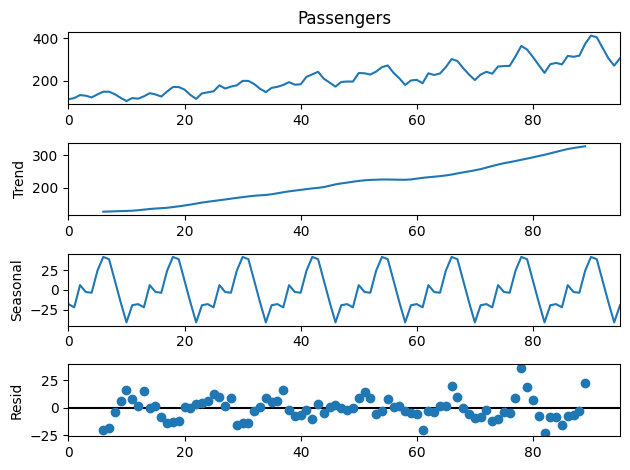

In [23]:
decompose_ts_add = seasonal_decompose(Airline.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

# ACF plots and PACF plots


A partial autocorrelation (PACF) is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


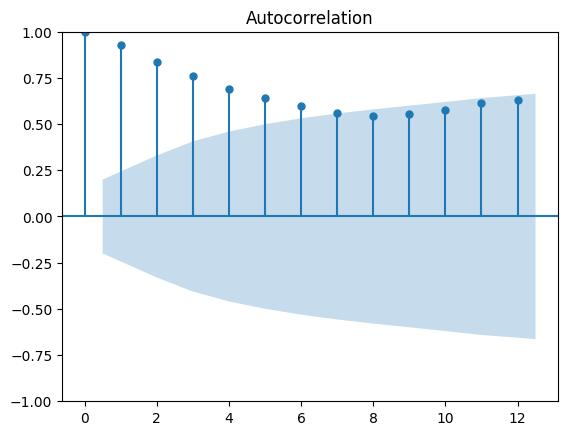

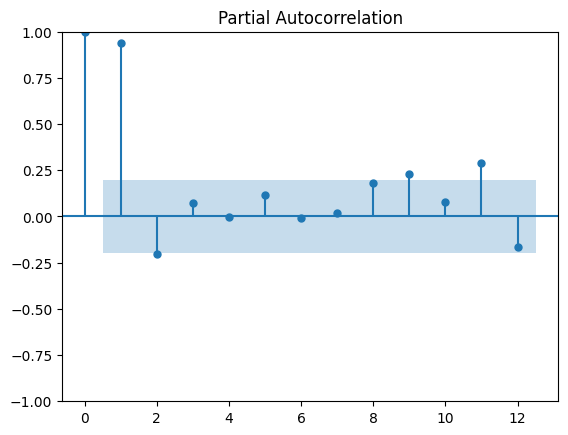

In [24]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(Airline.Passengers,lags=12)
tsa_plots.plot_pacf(Airline.Passengers,lags=12)
plt.show()

### Evaluation Metric MAPE

In [26]:
#Mean Absolute Percentage Error
def MAPE(pred,org):
    Month = np.abs((pred-org)/org)*100
    return np.mean(Month)

In [27]:
#Weighted Moving Average
import pandas as pd
import numpy as np 
df = pd.DataFrame({'X':range(100,30, -5)})
Month = np.array([0.1, 0.2, 0.3, 0.4])
df['MA'] = df['X'].rolling(4).apply(lambda x: np.sum(Month*x))
df

,X,MA
0,100,NaN
1,95,NaN
2,90,NaN
3,85,90.0
4,80,85.0
5,75,80.0
6,70,75.0
7,65,70.0
8,60,65.0
9,55,60.0


In [29]:
df=pd.DataFrame()
df['Passengers']=Airline["Passengers"]
df['WMA'] = df['Passengers'].rolling(4).apply(lambda x: np.sum(Month*x))
df

,Passengers,WMA
0,112,NaN
1,118,NaN
2,132,NaN
3,129,126.0
4,121,125.3
...,...,...
91,405,392.5
92,355,383.5
93,306,351.2
94,271,311.7


### Simple Exponential Method


In [31]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers) 

11.652581888339924

### Holt method 

In [32]:
# Holt method 
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers) 

<ipython-input-32-31e8e28b1106>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)


9.843474829332123

### Holts winter exponential smoothing with additive seasonality and additive trend


In [34]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",
                                         seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers) 

2.038558045831413

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [35]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",
                                         seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

1.186249403428661

## Final Model by combining train and test

In [37]:
hwe_model_add_add = ExponentialSmoothing(Airline["Passengers"],seasonal="add",trend="add",
                                         seasonal_periods=12).fit()

In [39]:
#Forecasting for next 10 Month periods
hwe_model_add_add.forecast(10)

96     319.235270
97     311.528386
98     350.278691
99     346.984976
100    351.845022
101    403.925707
102    440.566797
103    427.446477
104    376.628169
105    329.767502
dtype: float64